The first step is to import the requiered packages

In [1]:
from typing import List

import numpy as np
import tensorflow as tf
import h5py
import os
from tensorflow.python.keras.utils.np_utils import to_categorical
from keras.src.backend.tensorflow.sparse import zeros_int8
from tensorflow import Tensor


Then we get our dataset, for this we use a dataset consisting of 256 traces per key, and we have 256 keys. This will fit into a lot of memories, and will be suitable for our experimentation. If the datasets increase in size we will have to
split how we load it

In [2]:
dataset_name = "testing_set_new_kpts_2"
max_size = 1000000
num_sets = 20
set_size = max_size // num_sets
set_num = 0

In [5]:
#må byttes med der du har lagret filene
file_path = "C:\\Users\\Kaspar\\ChipWhisperer\\chipwhisperer\\jupyter\\courses\\sca101\\training_set.hdf5"
#for et stort datasett gjøres denne operasjonen flere ganger, og så laster vi det heller bit for bit opp i drive
#vår maks størrelse er 983 025 spor, som kommer av 1000000/65535 som gir oss 15 datasett bare glem det, her er det 500 per nøkkel
 #denne kan endres på slutten. Har gjort dette så mye at det nærmer seg vits i å lage metoder
start_index = set_num * set_size
stop_index = (set_num + 1) * set_size
with h5py.File(file_path, "r") as h5_file:
    plaintext_set = h5_file['data'][start_index:stop_index,]
    trace_set = h5_file['trace'][start_index:stop_index,]
    key_set = h5_file['key'][start_index:stop_index,]
    #sub_byte_out_set = h5_file['sub_byte_out'][start_index:stop_index,]

Before saving the dataset into groups using hdf5 we have to feature scale our trace into values from -1 to 1. This is a tip from scaaml to make the models converge. We also add another dimension to it to make it fit in a Conv1D layer


In [12]:
scaled_trace_set = tf.keras.layers.Rescaling(1. / 127.5, offset=-1)(trace_set)
scaled_trace_set = tf.expand_dims(trace_set, axis=-1)

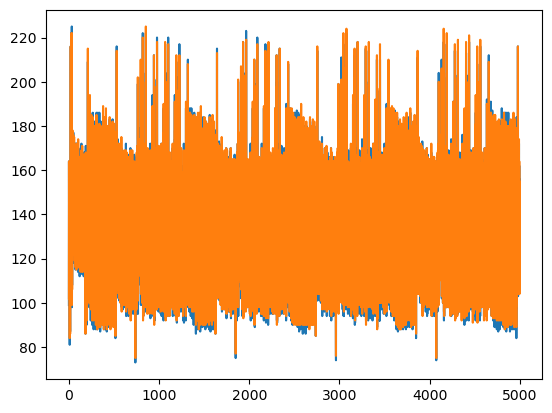

In [8]:
import matplotlib.pyplot as plt
plt.plot(trace_set[1])
plt.plot(trace_set[1000])


We pre compute our attack point, these are the key, sub byte in and sub byte out. We already have key and sub byte out from the capture, but we need to compute sub_byte in

In [10]:
num_traces = len(trace_set)
num_bytes = 16
sub_byte_in_set = np.zeros((num_traces, 16), dtype=np.uint8)

for i in range(num_traces):
    for byte_index in range(num_bytes):
        pts=plaintext_set[i][byte_index] ^ key_set[i,byte_index]
        sub_byte_in_set[i,byte_index] = pts
#check if this works
sub_byte_in_set = sub_byte_in_set


The next step is to transpose the matrixes so that they are on the form [byte][values]. this is done because we want to train one model for each byte. model_0_byte is trained on byte 0 for all the traces.

In [11]:
#sub_byte_out = np.transpose(sub_byte_out_set, (1, 0))
sub_byte_in = np.transpose(sub_byte_in_set, (1, 0))
key = np.transpose(key_set, (1, 0))


When this is done we create a dataset, and create groups representing a shard in it. The groups will consist of every trace for each key, and the name is the key made into hex. This is done to avoid using the same keys on train, test and validation sets

In [12]:
type(trace_set)
trace_set.shape

TensorShape([50000, 5000, 1])

In [13]:
num_shards = 256
num_traces_per_shard = 500
file_path = "\\...\\DAT255_SCA\\datasets"

#index to mark start and stop for slicing
group_start_index = 0
group_stop_index = num_traces_per_shard
dataset_name = dataset_name,set_num #change depending on the set you create

#create a new h5py file that will contain the shards
f = h5py.File(f"{dataset_name}.hdf5", "w")

#Loop trough the dataset, creating groups for every key
for i in range(num_shards):
    group_name = key_set[group_start_index].tobytes().hex()
    #Create one group representing a shard
    group = f.create_group(group_name, track_order=True)


    group.create_dataset("traces", data = trace_set[group_start_index:group_stop_index, :, :])
    group.create_dataset("key", data = key[:, group_start_index:group_stop_index])
    group.create_dataset("sub_bytes_in", data = sub_byte_in[:, group_start_index:group_stop_index])
    #group.create_dataset("sub_bytes_out", data = sub_byte_out[:, start_index:stop_index])

    #group_start_index += num_traces_per_shard
    #print(group_start_index)
    #group_stop_index += num_traces_per_shard
    #print(group_stop_index)
f.close()
set_num += 1

ValueError: Unable to synchronously create group (name already exists)

In [22]:
f.close()

256


Once this is done we take a look at the groups and datasets stored, and make sure they look like we intend

In [21]:
f = h5py.File(f"{dataset_name}.hdf5", "r")
i=0
for group in f.keys():
    print(group)
    i+=1
    print(i)
    print()
    for dset in f[group].keys():
        print(dset)
f.close()

e4f78821e0c1a7ea0a6ebeae0a042d5e
1

traces
key
sub_bytes_in


we can see that we have 256 different groups, representing shard

When we want to fetch data from the datasets, w

In [101]:
shard = []
attack_byte = 0
attack_point = "sub_bytes_in"
max_trace_length = 5000
num_traces = 256
full_key = False
x_List: List[Tensor] = []
y_List: List[Tensor] = []

#need to open the file to read any info
with (h5py.File(f"{dataset_name}.hdf5", "r")) as f:
    for group in f.keys():
        group_name = f[group]

        x_shard = group_name["traces"][:num_traces_per_shard, :5000, :]
        x_shard = tf.convert_to_tensor(x_shard, dtype="float32")

        y_shard = group_name["sub_bytes_in"][attack_byte]
        y_shard = y_shard[:num_traces_per_shard]
        y_shard = tf.keras.utils.to_categorical(y_shard, 256)
        y_shard = tf.convert_to_tensor(y_shard, dtype="uint8")


        x_List.append(x_shard)
        y_List.append(y_shard)
    x: Tensor = tf.concat(x_List, axis=0)
    y: Tensor = tf.concat(y_List, axis=0)


In [86]:
f.close()

In [104]:
y


<tf.Tensor: shape=(65536, 256), dtype=uint8, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)>

In [106]:
x_train = x

In [107]:
y_train = y

In [109]:
y_train.shape

TensorShape([65536, 256])

In [111]:
print(x_train[0])

tf.Tensor(
[[-0.07450974]
 [ 0.5529413 ]
 [ 0.3176471 ]
 ...
 [ 1.        ]
 [ 0.21568632]
 [ 0.6156864 ]], shape=(5000, 1), dtype=float32)


In [115]:
print(y_train[3])

tf.Tensor(
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(256,), dtype=uint8)


In [ ]:

with h5py.File(f"{dataset_name}_byte0.hdf5", "w") as f:
    f.create_dataset("x_train_byte0", data=x_train.numpy())
    f.create_dataset("y_train_byte0", data=y_train.numpy())
